# Analysis of Sphere packing efficeincy

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # For calculating QPSK decoding
import dill
from itertools import product, cycle

import tensorflow.keras.backend as K

System Configuration

In [37]:
blkSize     = 8
chDim       = 4

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

SNR_range_dB = np.arange( 0.0, 11.0, 1.0 )

one_hot_code = np.eye(inVecDim)

## Traditional Systems

### QAM

In [38]:
qam_map = np.array(list(map(list, product([-1, +1], repeat=blkSize))))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

noisePower = qam_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

QAM Avg. Tx Power: 8.0


### Agrell Map

In [39]:
agrell_map = []
if blkSize==2 and chDim==1:
    agrell_map = np.array([
        [ -1.0, -1.0 ],
        [ -1.0, 1.0 ],
        [ 1.0, -1.0 ],
        [ 1.0, 1.0 ]
    ])
elif blkSize==4 and chDim==2:
    agrell_map = np.array([
        [2.148934030042627, 0.0, 0.0, 0.0],
        [0.7347204676695321, 1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, -1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, 0.0, 1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, -1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, 0.0, 1.4142135623730951],
        [0.7347204676695321, 0.0, 0.0, -1.4142135623730951],
        [-0.6174729817844246, 1.0, 1.0, 1.0],
        [-0.6174729817844246, 1.0, 1.0, -1.0],
        [-0.6174729817844246, 1.0, -1.0, 1.0],
        [-0.6174729817844246, 1.0, -1.0, -1.0],
        [-0.6174729817844246, -1.0, 1.0, 1.0],
        [-0.6174729817844246, -1.0, 1.0, -1.0],
        [-0.6174729817844246, -1.0, -1.0, 1.0],
        [-0.6174729817844246, -1.0, -1.0, -1.0],
        [-1.6174729817844242, 0.0, 0.0, 0.0]
    ])
elif blkSize==8 and chDim==4:
    agrell_map = np.array([
        [ -256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 0.0, -256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ] ])
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Agrell Avg. Tx Power:", agrell_sym_pow )

noisePower = agrell_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

Agrell Avg. Tx Power: 137610.0


### Compute Metrics

QAM

In [40]:
qam_map = np.array(list(map(list, product([-1, +1], repeat=blkSize))))

qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

qam_d_min = np.unique(cdist(qam_map,qam_map))[1]
print("d_min:", qam_d_min )

qam_en = qam_sym_pow / (qam_d_min**2)
print("En:", qam_en)

QAM Avg. Tx Power: 8.0
d_min: 2.0
En: 2.0


Agrell

In [41]:
agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Agrell Avg. Tx Power:", agrell_sym_pow )

agrell_dmin = np.unique(cdist(agrell_map,agrell_map))[1]
print("d_min:", agrell_dmin )

agrell_en = agrell_sym_pow / (agrell_dmin**2)
print("En:", agrell_en)

Agrell Avg. Tx Power: 137610.0
d_min: 362.03867196751236
En: 1.0498809814453123


## Deep Learning Model

In [42]:
from CommVAE import CommVAE1hot
from AEOshea import AEOshea1hot

Specify models to analyze

In [43]:
model_summary = {}
results = {}

if blkSize==8 and chDim==4:
    model_summary = { 
        "[1]": "./models/08x04/cau_oshea_64_32_16_10dB_summary.dil",
        "(19)": "./models/08x04/cau_awgn_64_32_16_n020_sigma0500_summary.dil",
        "(23)": "./models/08x04/cau_rbf_64_32_16_n020_sigma0500_summary.dil",
        "CAU": "./models/08x04/cau_cau_64_32_16_n020_sigma0500_summary.dil",
        "(19)*": "./models/08x04/cau_awgn_64_32_16_n040_xsigma0300_summary.dil",
        "(23)*": "./models/08x04/cau_rbf_64_32_16_n040_xsigma0300_summary.dil",
        "CAU*": "./models/08x04/cau_cau_64_32_16_n040_xsigma0300_summary.dil"
    }
elif blkSize==4 and chDim==2:
    model_summary = {
        "[1]": "./models/04x02/cau_oshea_64_32_16_10dB_summary.dil",
        "(19)": "./models/04x02/cau_awgn_64_32_16_n020_sigma0500_summary.dil",
        "(23)": "./models/04x02/cau_rbf_64_32_16_n020_sigma0500_summary.dil",
        "CAU": "./models/04x02/cau_cau_64_32_16_n020_sigma0500_summary.dil",
        "(19)*": "./models/04x02/cau_awgn_64_32_16_n020_xsigma0300_summary.dil",
        "(23)*": "./models/04x02/cau_rbf_64_32_16_n020_xsigma0300_summary.dil",
        "CAU*": "./models/04x02/cau_cau_64_32_16_n020_xsigma0300_summary.dil"
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        "[1]": "./models/02x01/cau_oshea_64_32_16_10dB_summary.dil",
        "(19)": "./models/02x01/cau_awgn_64_32_16_n020_sigma0300_summary.dil",
        "(23)": "./models/02x01/cau_rbf_64_32_16_n020_sigma0300_summary.dil",
        "CAU": "./models/02x01/cau_cau_64_32_16_n020_sigma0300_summary.dil"
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

Check if all files exists

In [44]:
import os.path
for (model_exp, summary_file) in model_summary.items():
    log_msg = "{:40s}    {:70s}".format(model_exp,summary_file)
    if os.path.isfile(summary_file):
        log_msg += "EXISTS"
    else:
        log_msg += "NOT FOUND"
    print(log_msg)

[1]                                         ./models/08x04/cau_oshea_64_32_16_10dB_summary.dil                    EXISTS
(19)                                        ./models/08x04/cau_awgn_64_32_16_n020_sigma0500_summary.dil           EXISTS
(23)                                        ./models/08x04/cau_rbf_64_32_16_n020_sigma0500_summary.dil            EXISTS
CAU                                         ./models/08x04/cau_cau_64_32_16_n020_sigma0500_summary.dil            EXISTS
(19)*                                       ./models/08x04/cau_awgn_64_32_16_n040_xsigma0300_summary.dil          EXISTS
(23)*                                       ./models/08x04/cau_rbf_64_32_16_n040_xsigma0300_summary.dil           EXISTS
CAU*                                        ./models/08x04/cau_cau_64_32_16_n040_xsigma0300_summary.dil           EXISTS


For each of the model, compute $E_n$

In [45]:
for (model_exp,summary_file) in model_summary.items():
    summary_data = {}
    file_prefix = None
    # Load file
    results[model_exp] = {}
    with open(summary_file, "rb") as file:
        file_prefix = summary_file.split("_summary.dil")[0]
        summary_data = dill.load(file)
    for (modelid,(sym_pow,bler)) in summary_data.items():
        config_file = file_prefix + "_" + modelid + ".dil"
        config = {}
        model = None
        with open(config_file, "rb") as cfg_file:
            config = dill.load(cfg_file)
        if 'obj_fn' in config:    # obj_fn is there only for proposed CommVAE
#             print(config_file, "    CommVAE")
            model = CommVAE1hot()
        else:
#             print(config_file, "    AEOshea")
            model = AEOshea1hot()
        model.load_model(file_prefix+"_"+modelid)
        # Compute the Tx power and packing density
        dl_map, _ = model.encode(one_hot_code)
        dl_sym_pow = np.mean(np.sum(dl_map*dl_map,axis=1))
        unique_sym_distances = np.unique(cdist(dl_map,dl_map))
        if len(unique_sym_distances) == 1: # All distances are same and will be zero
            dl_d_min = np.inf  # This is not a valid point
            dl_en = np.nan
        else:
            dl_d_min = np.unique(cdist(dl_map,dl_map))[1]
            dl_en = dl_sym_pow / (dl_d_min**2)
#         print("sym_pow:", sym_pow, "    Model: ", dl_sym_pow, dl_d_min, dl_en)
        assert(np.abs(sym_pow-dl_sym_pow)<1e-3) # To make sure that we loaded right weights to model
        # save the results
        
        # Add this results only if this is a valid point
        if np.isfinite(dl_en):
            results[model_exp][modelid] = dl_en
        # Clear Session and Model
        K.clear_session()
        del model

Plot $E_n$ distribution

[1]     Min: 2.444152457172987     Max: 4.068557201089565
(19)     Min: 3.1995272656563922     Max: 9.738988254079944
(23)     Min: 3.2920909926784083     Max: 9.418428875673014
CAU     Min: 2.9279512931033223     Max: 9.46242329138743


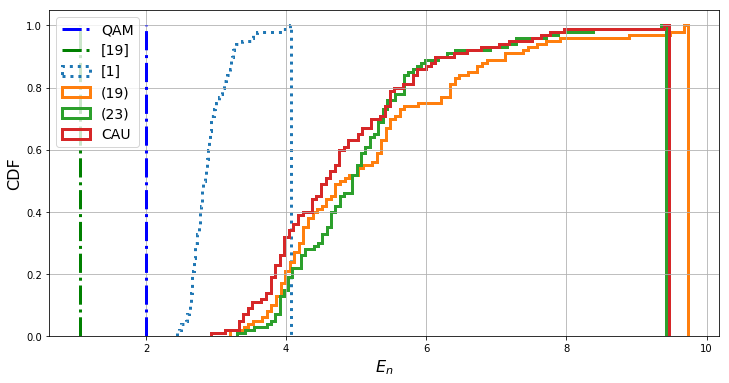

In [54]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
plt.figure(figsize=(12,6))
# plt.figure(figsize=(4*1.5,3*1.5))
plt.plot([qam_en,qam_en], [0,1], linewidth=3, label="QAM", color=next(colors), linestyle="-.")
plt.plot([agrell_en,agrell_en], [0,1], linewidth=3, label="[19]", color=next(colors), linestyle="-.")
selected_max_en = []
for (model_exp,density_data) in results.items():
    d = np.array([ en for (_,en) in density_data.items() ])
    if len(d) < 100:
        continue
#     if np.max(d) < 1.4*qam_en: # Avoid un-necessary models
    plt.hist(d, bins=100, cumulative=True, density=True, histtype="step", 
#              label= "{} [{}]".format(model_exp,len(d)), 
             label=model_exp,
#              color=next(colors), 
#              color=np.random.rand(3,),
             linewidth=3, 
             linestyle=":" if "Oshea" in model_exp or "[1]" in model_exp else "-")
    selected_max_en.append(np.max(d)) if np.max(d) < 1.5*qam_en else None
    print(model_exp, "    Min:", np.min(d), "    Max:", np.max(d))
# plt.xlim([0.95*agrell_en,np.max(selected_max_en)*1.05])
plt.grid()
plt.legend(loc='upper left', prop={'size':14})
# plt.title("Packing Density for ({},{})".format(blkSize,chDim), fontdict={'fontsize':18})
plt.xlabel("$E_n$", fontdict={'fontsize':16})
plt.ylabel("CDF", fontdict={'fontsize':16})
# plt.savefig("output_awgn_en_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
# plt.savefig("output_awgn_en_{:02d}x{:02d}.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')
plt.savefig("output_awgn_en_{:02d}x{:02d}.png".format(blkSize,chDim), format='png', bbox_inches='tight')

Plot constellation for best models

Text(0.5, 0.98, 'Agrell  $E_n=0.7738$')

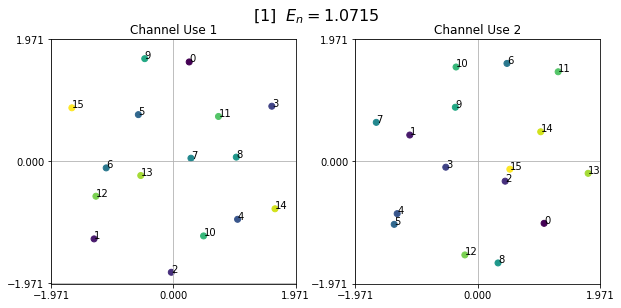

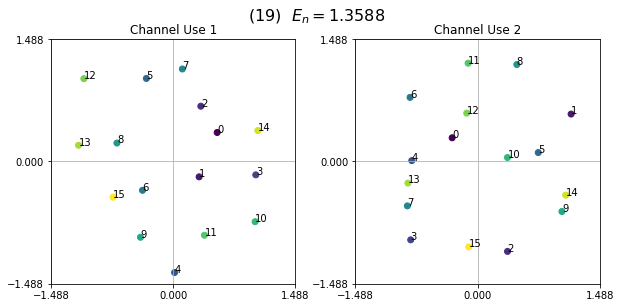

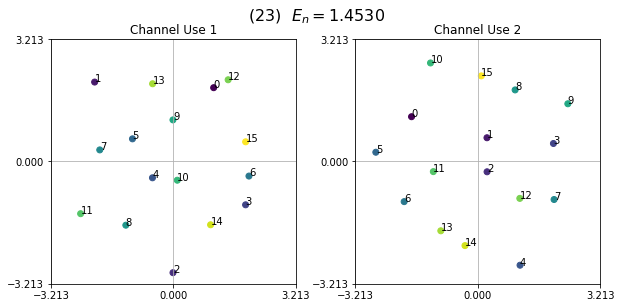

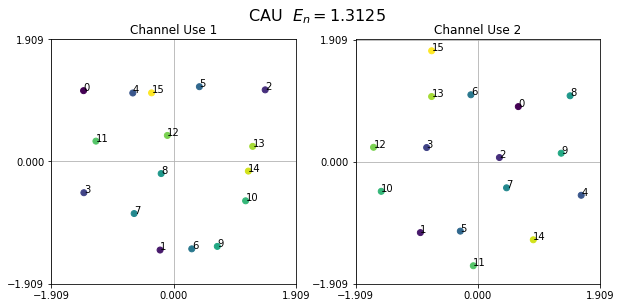

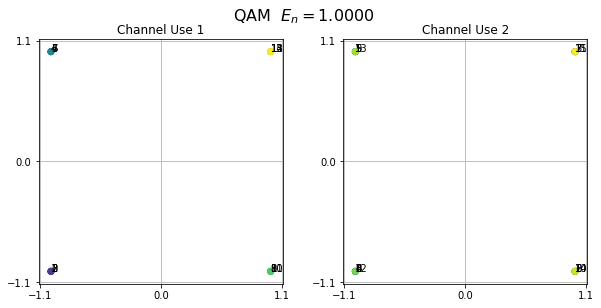

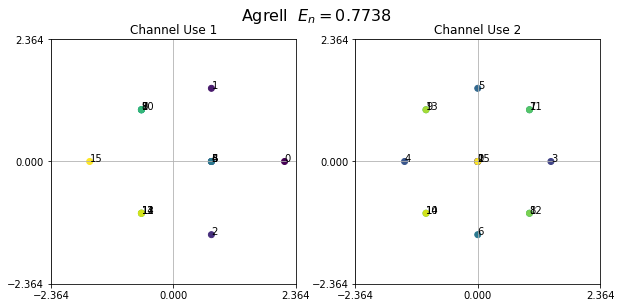

In [24]:
for (model_exp,density_data) in results.items():
    file_prefix = model_summary[model_exp].split("_summary.dil")[0]
    modelid = min(density_data, key=density_data.get)
    config_file = file_prefix + "_" + modelid + ".dil"
    config = {}
    model = None
    with open(config_file, "rb") as cfg_file:
        config = dill.load(cfg_file)
    if 'obj_fn' in config:    # obj_fn is there only for proposed CommVAE
        model = CommVAE1hot()
    else:
        model = AEOshea1hot()
    model.load_model(file_prefix+"_"+modelid)
    # Compute TX Map
    dl_map, _ = model.encode(one_hot_code)
    max_mag = np.max(np.abs(dl_map))
    tick_points = [ -1.1*max_mag, 0.0, +1.1*max_mag ]
    # Plot TX Map
    fig, ax = plt.subplots(1, chDim, figsize=(5*chDim,4.5))
    for i in range(chDim):
        _ax = ax if chDim==1 else ax[i]
        _ax.scatter(dl_map[:,i],dl_map[:,i+chDim],c=np.arange(inVecDim))
        for j in range(inVecDim):
            _ax.annotate( j, (dl_map[j,i],dl_map[j,i+chDim]) )
        _ax.set_title( "Channel Use {}".format(i+1) )
        _ax.grid()
        _ax.set_xticks(tick_points)
        _ax.set_yticks(tick_points)
        _ax.set_aspect('equal')
    fig.suptitle("{}  $E_n={:5.4f}$".format(model_exp,density_data[modelid]), fontsize=16)
      
    # Clear Session and Model
    K.clear_session()
    del model
    
# Plot QAM Model
fig, ax = plt.subplots(1, chDim, figsize=(5*chDim,4.5))
max_mag = np.max(np.abs(qam_map))
tick_points = [ -1.1*max_mag, 0.0, +1.1*max_mag ]    
for i in range(chDim):
    _ax = ax if chDim==1 else ax[i]
    _ax.scatter(qam_map[:,2*i], qam_map[:,2*i+1], c=np.arange(inVecDim))
    for j in range(inVecDim):
        _ax.annotate( j, (qam_map[j,2*i],qam_map[j,2*i+1]) )
    _ax.set_title( "Channel Use {}".format(i+1) )
    _ax.grid()
    _ax.set_xticks(tick_points)
    _ax.set_yticks(tick_points)
    _ax.set_aspect('equal')
fig.suptitle("{}  $E_n={:5.4f}$".format("QAM",qam_en), fontsize=16)

# Plot Agrell Model
fig, ax = plt.subplots(1, chDim, figsize=(5*chDim,4.5))
max_mag = np.max(np.abs(agrell_map))
tick_points = [ -1.1*max_mag, 0.0, +1.1*max_mag ]    
for i in range(chDim):
    _ax = ax if chDim==1 else ax[i]
    _ax.scatter(agrell_map[:,2*i], agrell_map[:,2*i+1], c=np.arange(inVecDim))
    for j in range(inVecDim):
        _ax.annotate( j, (agrell_map[j,2*i],agrell_map[j,2*i+1]) )
    _ax.set_title( "Channel Use {}".format(i+1) )
    _ax.grid()
    _ax.set_xticks(tick_points)
    _ax.set_yticks(tick_points)
    _ax.set_aspect('equal')
fig.suptitle("{}  $E_n={:5.4f}$".format("Agrell",agrell_en), fontsize=16)